In [17]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [32]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [33]:
DIRECTORY = "C:/Users/SAI KARTHIK/Downloads/Projects (Download me But will only work if you have python 3.7_3.8)/Projects/PrepInsta Video Based Facemask Detection/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [34]:
import os
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

[INFO] loading images...


D:\Anaconda\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [35]:
# perform encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [36]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [37]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

C:\Users\SAI KARTHIK\AppData\Local\Temp\ipykernel_7632\3763301706.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))


In [38]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [39]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:layer.trainable = False

In [40]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
# Check if the model can process the validation data
loss, accuracy = model.evaluate(testX, testY, batch_size=BS)
print(f"Validation loss: {loss}, Validation accuracy: {accuracy}")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
              steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),
              validation_steps=len(testX) // BS,
              epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


D:\Anaconda\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 631ms/step - accuracy: 0.4832 - loss: 0.8076
Validation loss: 0.8052650094032288, Validation accuracy: 0.46936115622520447
Epoch 1/20


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7275 - loss: 0.5681 - val_accuracy: 0.9804 - val_loss: 0.1601
Epoch 2/20
 1/95 ━━━━━━━━━━━━━━━━━━━━ 56s 604ms/step - accuracy: 0.9688 - loss: 0.1542

D:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9688 - loss: 0.0779 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9649 - loss: 0.1679 - val_accuracy: 0.9870 - val_loss: 0.0837
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9688 - loss: 0.0956 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9753 - loss: 0.0998 - val_accuracy: 0.9909 - val_loss: 0.0606
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.0856 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9769 - loss: 0.0790 - val_accuracy: 0.9922 - val_loss: 0.0495
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.0402 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9811 - loss: 0.0647 - val_ac

In [41]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.h5")

[INFO] evaluating network...
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 597ms/step


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


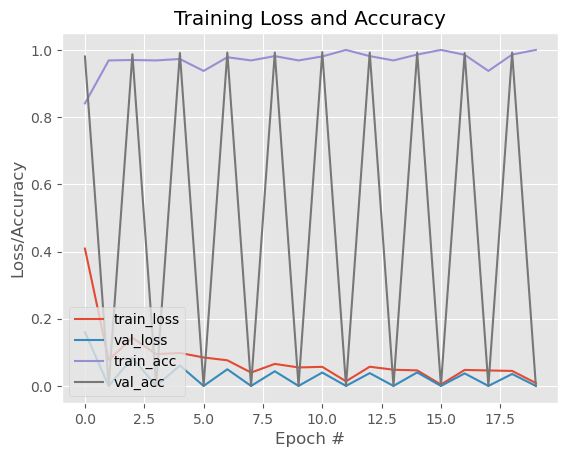

In [42]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")